In [ ]:
import torch
import torch.nn as nn
from strokes import StrokePatientsMIDataset, StrokePatientsMIProcessedDataset
from strokesdict import STROKEPATIENTSMI_LOCATION_DICT
from torcheeg.transforms import Select,BandSignal,Compose
from to import ToGrid, ToTensor
from downsample import SetSamplingRate
from baseline import BaselineCorrection

dataset = StrokePatientsMIDataset(root_path='./subdataset',
                                  io_path='.torcheeg/datasets_1745478591849_L5nX8',
                        chunk_size=500,  # 1 second
                        overlap = 250,
                        offline_transform=Compose(
                                [BaselineCorrection(),
                                SetSamplingRate(origin_sampling_rate=500,target_sampling_rate=128),
                                BandSignal(sampling_rate=128,band_dict={'frequency_range':[8,40]})
                                ]),
                        online_transform=Compose(
                                [ToGrid(STROKEPATIENTSMI_LOCATION_DICT),ToTensor()]),
                        label_transform=Select('label'),
                        num_worker=8
)
print(dataset[0][0].shape) #EEG shape:torch.Size([1, 128, 9, 9])
print(dataset[0][1])  # label (int)
print(len(dataset))

In [ ]:
import torch
from swin import SwinTransformer

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 生成一个形状为 (4,1,128,9,9) 的全1张量
x = torch.ones(4, 1, 128, 9, 9).to(device)

model = SwinTransformer(patch_size=(8,1,1),
                        depths=(2, 2, 4),
                        num_heads=(2,2,3),
                        window_size=(4,3,3)
                        ).to(device)

y = model(x)
print(y.shape)

In [ ]:
from swin import SwinTransformer

HYPERPARAMETERS = {
    "seed": 42,
    "batch_size": 16,
    "lr": 1e-5,
    "weight_decay": 1e-4,
    "num_epochs": 50,
}
from torcheeg.model_selection import KFoldPerSubjectGroupbyTrial
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torch.utils.data import DataLoader
from classifier import ClassifierTrainer

k_fold = KFoldPerSubjectGroupbyTrial(
    n_splits=4,
    shuffle=True,
    # split_path='.torcheeg/model_selection_1741918660674_jp0WB',
    random_state=42)

training_metrics = []
test_metrics = []
attn_list = []


for i, (training_dataset, test_dataset) in enumerate(k_fold.split(dataset)):
    model = SwinTransformer(patch_size=(8,3,3), 
                            depths=(2, 2, 2),
                            num_heads=(2,2,3),
                            window_size=(3,3,3)
                            ) # T, W, H 同时缩小
    trainer = ClassifierTrainer(model=model,
                                num_classes=2,
                                lr=HYPERPARAMETERS['lr'],
                                weight_decay=HYPERPARAMETERS['weight_decay'],
                                metrics=["accuracy"],
                                accelerator="gpu")
    training_loader = DataLoader(training_dataset,
                             batch_size=HYPERPARAMETERS['batch_size'],
                             shuffle=True)
    test_loader = DataLoader(test_dataset,
                             batch_size=HYPERPARAMETERS['batch_size'],
                             shuffle=False)
    # 提前停止回调
    early_stopping_callback = EarlyStopping(
        monitor='train_loss',
        patience=50,
        mode='min',
        verbose=True
    )
    trainer.fit(training_loader,
                test_loader,
                max_epochs=HYPERPARAMETERS['num_epochs'],
                callbacks=[early_stopping_callback],
                # enable_progress_bar=True,
                enable_model_summary=False,
                limit_val_batches=0.0)
    training_result = trainer.test(training_loader,
                                   enable_progress_bar=True,
                                   enable_model_summary=True)[0]
    test_result = trainer.test(test_loader,
                               enable_progress_bar=True,
                               enable_model_summary=True)[0]
    attn_list.append(model.layers[2].blocks[0].attn.attn_scores)
    training_metrics.append(training_result["test_accuracy"])
    test_metrics.append(test_result["test_accuracy"])

In [ ]:
print(test_metrics)
avg = sum(test_metrics) / len(test_metrics)
print(avg)

In [ ]:
print(len(attn_list))
print(attn_list[3].shape)
# print(model.layers[0].blocks[0].attn.attn_scores)
sample = attn_list[3]
sample = torch.mean(sample, dim=2)
print(sample.shape)


In [ ]:
# sample = sample.masked_fill(sample < 0.0375, 0)
# sample = torch.mean(sample, dim=1)
print(sample[2]*1000)
v = sample[2]

In [13]:
# 归一化到 [0, 1]
sample_min = sample[2].min()
sample_max = sample[2].max()
v = (sample[2] - sample_min) / (sample_max - sample_min + 1e-8)

# 拉大差距
v = v ** 10

In [ ]:
print(model.layers[0].blocks[1].attn.attn_scores)

In [ ]:
attn = attn_list[3][0]
print(attn.shape)
attn = torch.mean(attn, dim=1)  # 形状变为 (16, 36, 36)
attn = torch.mean(attn,dim=1)   # 计算所有token对一个token的平均影响力
attn = attn.reshape(16,16,3,3)
attn = torch.mean(attn, dim=1)  # 形状变为 (16, 36, 36)
print(attn.shape)


In [ ]:
v = v.reshape(3,3,3)
v = torch.mean(v, dim=0)
print(v)

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# 示例注意力权重 (3,3)
attention_weights = v
print(attention_weights)

# 画热力图
plt.figure(figsize=(5, 5))
sns.heatmap(attention_weights.numpy(), annot=True, cmap="viridis", fmt=".2f",
            xticklabels=["Col 1", "Col 2", "Col 3"],
            yticklabels=["Row 1", "Row 2", "Row 3"])

plt.title("Spatial Attention Weights")
plt.xlabel("Feature Map Width")
plt.ylabel("Feature Map Height")
plt.show()


In [1]:
from swin_CAM import SwinTransformer
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 生成一个形状为 (4,1,128,9,9) 的全1张量
input_tensor = torch.randn(1, 1, 128, 9, 9).to(device)


model = SwinTransformer(patch_size=(8,1,1),
                        depths=(2, 2, 4),
                        num_heads=(2,2,3),
                        window_size=(4,3,3)
                        ).to(device)

model.eval()

target_layers = [model.layers[-1].blocks[-1].norm1]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [2]:
def get_shape(module, input, output):
    print(f"Layer output shape: {output.shape}")

target_layer = model.layers[-1].blocks[-1].norm1
handle = target_layer.register_forward_hook(get_shape)

# 运行前向传播
with torch.no_grad():
    _ = model(input_tensor)  # 触发hook打印形状
handle.remove()  # 必须移除hook防止内存泄漏

Layer output shape: torch.Size([1, 36, 1536])


(1, 4, 3, 3)
(1, 128, 9, 9)
(9, 9)


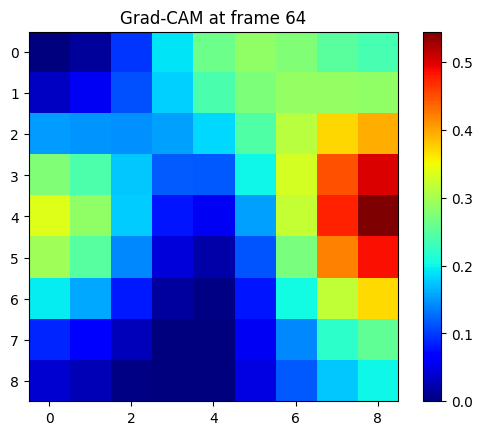

In [6]:
from pytorch_grad_cam import GradCAM
import matplotlib.pyplot as plt
# --- 自定义形状转换函数 ---
def reshape_transform(tensor, original_T=128, original_H=9, original_W=9):
    """
    输入: [B, N=36, C=1536] 
    输出: [B, C, H'=3, W'=3] (时间平均 + 空间对齐)
    """
    B, N, C = tensor.shape
    
    # 1. 将36分解为4(T')×3(H')×3(W') → [B,4,3,3,C]
    restored = tensor.view(B, 4, 3, 3, C)
    
    # 3. 调整为CAM需要的 [B,C,H',W']
    return restored.permute(0, 4, 1, 2, 3)

cam = LayerCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)

# 生成 CAM 热力图
grayscale_cam = cam(input_tensor=input_tensor)
print(grayscale_cam.shape)
grayscale_cam = grayscale_cam[0, :]  # 取第一个样本的热图，形状：[T', H', W']

# 可视化热图的某一帧（例如中间一帧）
t_index = grayscale_cam.shape[0] // 2
cam_frame = grayscale_cam[t_index]
print(cam_frame.shape)
plt.imshow(cam_frame, cmap='jet')
plt.title(f'Grad-CAM at frame {t_index}')
plt.colorbar()
plt.savefig("gradcam_output.png")
plt.show()

In [1]:
from swin_CAM import SwinTransformer
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 生成一个形状为 (4,1,128,9,9) 的全1张量
input_tensor = torch.randn(1, 1, 128, 9, 9).to(device)


model = SwinTransformer(patch_size=(8,1,1),
                        depths=(2, 2, 4),
                        num_heads=(2,2,3),
                        window_size=(4,3,3)
                        ).to(device)

model.eval()

target_layers = [model.layers[-1].blocks[-1].norm1]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [2]:
from pytorch_grad_cam import GradCAM

class EEGSwinCAM(LayerCAM):
    def __init__(self, model, target_layers, original_shape):
        self.original_shape = original_shape
        super().__init__(model, target_layers, self.reshape_transform)
    
    def reshape_transform(self, tensor):
        B, N, D = tensor.shape
     
        patch_T = 4
        patch_H = 3
        patch_W = 3
        
        return tensor.reshape(B, patch_T, patch_H, patch_W, D).permute(0,4,1,2,3)

# 使用示例
input_tensor = torch.randn(1, 1, 128, 9, 9)
cam = EEGSwinCAM(model, target_layers, input_tensor.shape)
cam_map = cam(input_tensor)  # 形状 [1,4,3,3]
print(cam_map.shape)

(1, 128, 9, 9)


In [1]:
import torch
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# TODO: 替换为你的 EEG Swin Transformer 模型类
from swin_CAM import SwinTransformer  

# 假设目标层输出为 (batch, 36, 1536)，即 6×6 patch，1536 维特征
def reshape_transform(tensor, time=4, height=3, width=3):
    # 输入形状: (B, 36, 1536)
    B, seq_len, C = tensor.size()

    result = tensor.reshape(B, time, height, width, C)
    # result = torch.mean(result, dim=1)
    result = result.permute(0, 4, 1, 2, 3)  # (B, C, H, W)
    return result

# 加载模型
model = SwinTransformer(patch_size=(8,1,1),
                        depths=(2, 2, 4),
                        num_heads=(2,2,3),
                        window_size=(4,3,3)
                        )
model.eval()
target_layers = [model.layers[-1].blocks[-1].norm2]  # 替换为你的实际目标层

# 是否使用GPU
use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()

# 示例 EEG 输入 (batch, 1, 128, 9, 9)
eeg_input = torch.randn(2, 1, 128, 9, 9)  # 假设 batch size 为 2
if use_cuda:
    eeg_input = eeg_input.cuda()

# 初始化 GradCAM
cam = GradCAM(model=model, 
              target_layers=target_layers, 
              reshape_transform=reshape_transform)

# 可选：设定目标类别（如果是分类问题）
targets = None  # 或 [ClassifierOutputTarget(class_id)]

# 获取灰度 CAM 输出: (batch, H, W)
grayscale_cam = cam(input_tensor=eeg_input, targets=targets)

# 输出结果
print("CAM shape:", grayscale_cam.shape)  # 应为 (batch_size, 6, 6)
print("CAM values for sample 0:\n", grayscale_cam[0])


/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


(2, 1536, 4, 3, 3)
cam: (2, 4, 3, 3)
CAM shape: (2, 3, 3)
CAM values for sample 0:
 [[0.28417727 0.44186538 0.38192427]
 [0.09306236 0.         0.        ]
 [0.16707207 0.9999847  0.55298334]]
